In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_1.csv")


In [18]:
dataFrame = pd.read_csv(resultsPath)

dataFrame["vectorSize"] = dataFrame["vectorSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Vector sizes:", sorted(dataFrame["vectorSize"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 210
Modes: ['min' 'max']
Vector sizes: [1000000, 5000000, 10000000]
Process counts: [1, 2, 4, 6, 8, 16, 32]


,testType,vectorSize,numProcesses,mode,timeSeconds,resultValue,runIndex,mpiEnv
0,MPI_1,1000000,1,min,0.000828,2.139230,1,MPICH_NUM_PROC=1
1,MPI_1,1000000,1,min,0.000704,1.097932,2,MPICH_NUM_PROC=1
2,MPI_1,1000000,1,min,0.000710,1.171792,3,MPICH_NUM_PROC=1
3,MPI_1,1000000,1,min,0.000705,0.146061,4,MPICH_NUM_PROC=1
4,MPI_1,1000000,1,min,0.000711,0.293468,5,MPICH_NUM_PROC=1
5,MPI_1,1000000,2,min,0.000794,2.836955,1,MPICH_NUM_PROC=2
6,MPI_1,1000000,2,min,0.000716,0.096917,2,MPICH_NUM_PROC=2
7,MPI_1,1000000,2,min,0.000749,1.088143,3,MPICH_NUM_PROC=2


In [19]:
groupedFrame = dataFrame.groupby(["mode","vectorSize","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","vectorSize","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,mode,vectorSize,numProcesses,median,mean,std,count
0,max,1000000,1,0.000552,0.000564,0.000017,5
1,max,1000000,2,0.000633,0.000617,0.000038,5
2,max,1000000,4,0.000875,0.000865,0.000048,5
3,max,1000000,6,0.001150,0.001136,0.000057,5
4,max,1000000,8,0.001562,0.001568,0.000123,5
5,max,1000000,16,0.002919,0.002896,0.000063,5
6,max,1000000,32,0.006513,0.006474,0.000249,5
7,max,5000000,1,0.002855,0.002868,0.000023,5
8,max,5000000,2,0.003044,0.003014,0.000126,5
9,max,5000000,4,0.003292,0.003267,0.000167,5


In [20]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, vectorSizeVal), subFrame in groupedDf.groupby(["mode","vectorSize"]):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,vectorSize,numProcesses,median,mean,std,count,speedup,efficiency
0,max,1000000,1,0.000552,0.000564,0.000017,5,1.000000,1.000000
1,max,1000000,2,0.000633,0.000617,0.000038,5,0.872038,0.436019
2,max,1000000,4,0.000875,0.000865,0.000048,5,0.630857,0.157714
3,max,1000000,6,0.001150,0.001136,0.000057,5,0.480000,0.080000
4,max,1000000,8,0.001562,0.001568,0.000123,5,0.353393,0.044174
5,max,1000000,16,0.002919,0.002896,0.000063,5,0.189106,0.011819
6,max,1000000,32,0.006513,0.006474,0.000249,5,0.084754,0.002649
7,max,5000000,1,0.002855,0.002868,0.000023,5,1.000000,1.000000
8,max,5000000,2,0.003044,0.003014,0.000126,5,0.937911,0.468955
9,max,5000000,4,0.003292,0.003267,0.000167,5,0.867254,0.216813


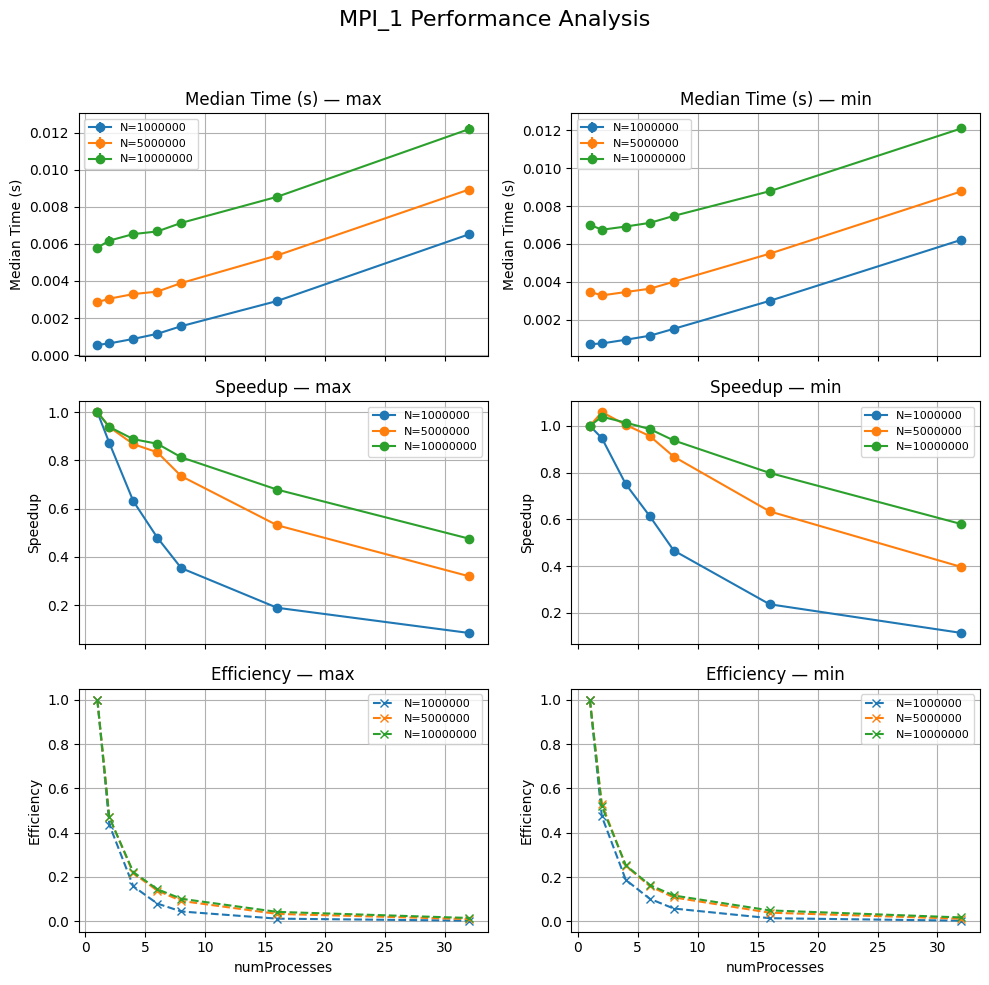

In [21]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

fig, axes = plt.subplots(3, len(modes), figsize=(5 * len(modes), 10), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(3)])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        for vectorSizeVal in sorted(perfFrame["vectorSize"].unique()):
            subFrame = perfFrame[(perfFrame["mode"]==modeVal) & (perfFrame["vectorSize"]==vectorSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={vectorSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={vectorSizeVal}")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == 2:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("MPI_1 Performance Analysis", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [22]:
for modeVal in perfFrame["mode"].unique():
    pivotTime = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numProcesses", columns="vectorSize", values="median")
    pivotSpeedup = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numProcesses", columns="vectorSize", values="speedup")
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(pivotTime)
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(pivotSpeedup)

summaryRows = []
for (modeVal, vectorSizeVal), sub in perfFrame.groupby(["mode","vectorSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "vectorSize": vectorSizeVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Process": medianAtOne
    })
summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","vectorSize"])
display(summaryAnalysisFrame)



=== mode: max — median time (s) ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,0.000552,0.002855,0.005794
2,0.000633,0.003044,0.006174
4,0.000875,0.003292,0.006526
6,0.001150,0.003425,0.006668
8,0.001562,0.003887,0.007129
16,0.002919,0.005376,0.008536
32,0.006513,0.008926,0.012181



=== mode: max — speedup ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,1.000000,1.000000,1.000000
2,0.872038,0.937911,0.938452
4,0.630857,0.867254,0.887833
6,0.480000,0.833577,0.868926
8,0.353393,0.734500,0.812737
16,0.189106,0.531064,0.678772
32,0.084754,0.319852,0.475659



=== mode: min — median time (s) ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,0.000710,0.003479,0.007016
2,0.000749,0.003285,0.006750
4,0.000946,0.003464,0.006920
6,0.001157,0.003637,0.007112
8,0.001521,0.004006,0.007481
16,0.002997,0.005485,0.008783
32,0.006220,0.008776,0.012098



=== mode: min — speedup ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,1.000000,1.000000,1.000000
2,0.947931,1.059056,1.039407
4,0.750529,1.004330,1.013873
6,0.613656,0.956558,0.986502
8,0.466798,0.868447,0.937843
16,0.236904,0.634275,0.798816
32,0.114148,0.396422,0.579931


,mode,vectorSize,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Process
0,max,1000000,1,1.000000,1.000000,0.000552
1,max,5000000,1,1.000000,1.000000,0.002855
2,max,10000000,1,1.000000,1.000000,0.005794
3,min,1000000,1,1.000000,1.000000,0.000710
4,min,5000000,2,1.059056,0.529528,0.003479
5,min,10000000,2,1.039407,0.519704,0.007016
